In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import os
from bambi import Model

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
from glam.plots import plot_correlation

/Users/felixmolter/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# load parameter recovery results:
recovery_dir = os.path.join('results', 'parameter_recovery')
files = [file for file in os.listdir(recovery_dir)
         if file.endswith('.csv')]

results = []

parameters = ['v', 'gamma', 's', 'tau']

dataset = np.array(39 * ['krajbich2010'] + 30 * ['krajbich2011'] + 24 * ['folke2016'] + 25 * ['tavares2017'])

for file in files:
    _, _, subject, _, _ = file.split('_')
    subject = int(subject)
    result = pd.read_csv(os.path.join(recovery_dir, file), index_col=0)
    results.append(pd.DataFrame(dict(subject=np.ones(len(parameters)).astype(int) * subject,
                                     dataset=[dataset[subject]] * len(parameters),
                                     parameter=parameters,
                                     generating=result.loc[[parameter + '__0_0'
                                                            for parameter in parameters],
                                                           'generating'],
                                     recovered=result.loc[[parameter + '__0_0'
                                                           for parameter in parameters],
                                                          'MAP']
                                    )
                               )
                  )

results = pd.concat(results).sort_values(['subject', 'parameter']).reset_index(drop=True)

In [3]:
results.head()

,subject,dataset,parameter,generating,recovered
0,0,krajbich2010,gamma,0.790000,0.980000
1,0,krajbich2010,s,0.010750,0.010854
2,0,krajbich2010,tau,0.490000,0.810000
3,0,krajbich2010,v,0.000084,0.000074
4,1,krajbich2010,gamma,-0.130000,0.280000


In [4]:
def figure_si_6(results, figsize=(7.5, 2.), colors=None, fontsize=8, plot_legend=False):

    datasets = ['krajbich2010', 'krajbich2011', 'folke2016', 'tavares2017']

    if colors is None:
        colors = np.array(['C{}'.format(i)
                           for i in range(results['dataset'].unique().size)])

    parameters = ['v', 'gamma', 's', 'tau']
    parameter_labels = [r'$v$', r'$\gamma$', r'$\sigma$', r'$\tau$']
    parameter_limits = [(0, 0.000225), (-1.5, 1.25), (0, 0.0225), (0, 5.5)]
    parameter_ticks = [[0, 0.0001, 0.0002], [-1, 0, 1], [0, 0.01, 0.02], [0, 1, 2, 3, 4, 5]]
    fig, axs = plt.subplots(1, 4, figsize=figsize)

    for p, (parameter, label, limits, ticks) in enumerate(zip(parameters, 
                                                              parameter_labels,
                                                              parameter_limits,
                                                              parameter_ticks)):
        results_parameter = results.loc[results['parameter'] == parameter]

        color_idx = pd.Categorical(results_parameter['dataset'], categories=datasets, ordered=True).codes.astype(int)

        axs[p].scatter(results_parameter['generating'],
                       results_parameter['recovered'],
                       color=colors[color_idx],
                       marker='+')
        axs[p].set_xlim(limits)
        axs[p].set_ylim(limits)
        axs[p].set_title(label, fontsize=fontsize)
        axs[p].set_xlabel('Generating', fontsize=fontsize)
        axs[p].set_ylabel('Recovered', fontsize=fontsize)
        axs[p].set_xticks(ticks)
        axs[p].set_yticks(ticks)

    if plot_legend:
        patches = [mpatches.Rectangle((0, 0), 0.5, 1, fc="C{}".format(i))
                   for i in range(len(datasets))]
        axs[0].legend(patches,
                      ['Krajbich 2010', 'Krajbich 2011', 'Folke 2016', 'Tavares 2017'],
                      loc='upper left',
                      handlelength=1, handleheight=1,
                      fontsize=6,
                      frameon=False)

    # Labels
    for ax in axs.ravel():
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Font sizes
        ax.tick_params(axis='both', labelsize=8)

        # Plot diagonal
        ax.plot(ax.get_xlim(), ax.get_xlim(), color='black', alpha=1, linewidth=1, zorder=-1)

    fig.tight_layout()

    return fig, axs


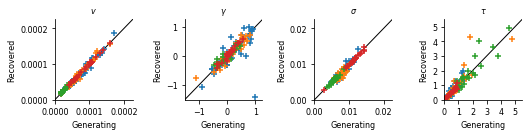

In [5]:
figure_si_6(results);
plt.savefig('results/figures/si_figure_6_parameter_recovery.png', dpi=330, bbox_inches='tight')
plt.show()

# Bias Analyses

In [6]:
df = results.melt(id_vars=['subject', 'dataset', 'parameter'], value_vars=['generating', 'recovered'], var_name='type').sort_values(['subject', 'parameter']).reset_index(drop=True)
df['is_recovered'] = (df['type'] == 'recovered').astype(float)
df.head()

,subject,dataset,parameter,type,value,is_recovered
0,0,krajbich2010,gamma,generating,0.790000,0.0
1,0,krajbich2010,gamma,recovered,0.980000,1.0
2,0,krajbich2010,s,generating,0.010750,0.0
3,0,krajbich2010,s,recovered,0.010854,1.0
4,0,krajbich2010,tau,generating,0.490000,0.0


In [7]:
from pymc3 import plot_posterior

v


/Users/felixmolter/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/felixmolter/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4385: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 9,010.2: 100%|██████████| 50000/50000 [00:43<00:00, 1161.92it/s]   
Finished [100%]: Average Loss = 8,998.8
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [value_sd_interval__, is_recovered|dataset_offset, is_recovered|dataset_sd_log__, 1|dataset_offset, 1|dataset_sd_log__, is_recovered, Intercept]
100%|██████████| 30500/30500 [42:34<00:00, 11.94it/s]
The number of effective samples is smaller than 25% for some parameters.


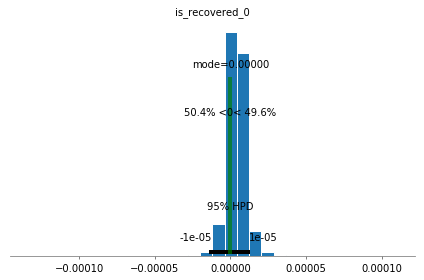

gamma


/Users/felixmolter/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/felixmolter/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4385: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 135.44:  36%|███▌      | 17881/50000 [00:15<00:27, 1155.19it/s]
Convergence archived at 17900
Interrupted at 17,899 [35%]: Average Loss = 601.03
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [value_sd_interval__, is_recovered|dataset_offset, is_recovered|dataset_sd_log__, 1|dataset_offset, 1|dataset_sd_log__, is_recovered, Intercept]
100%|██████████| 30500/30500 [02:52<00:00, 177.20it/s]
There were 954 divergences after tuning. Increase `target_accept` or reparameterize.
There 

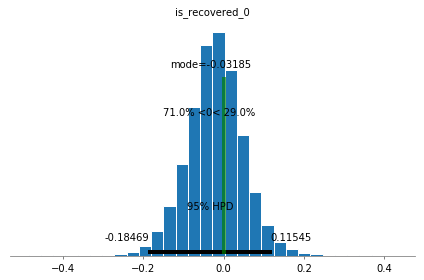

s


/Users/felixmolter/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/felixmolter/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4385: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = -1,116:  92%|█████████▏| 45834/50000 [00:39<00:03, 1151.87it/s]    
Convergence archived at 45900
Interrupted at 45,899 [91%]: Average Loss = 3.4354e+06
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [value_sd_interval__, is_recovered|dataset_offset, is_recovered|dataset_sd_log__, 1|dataset_offset, 1|dataset_sd_log__, is_recovered, Intercept]
100%|██████████| 30500/30500 [13:46<00:00, 36.92it/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
T

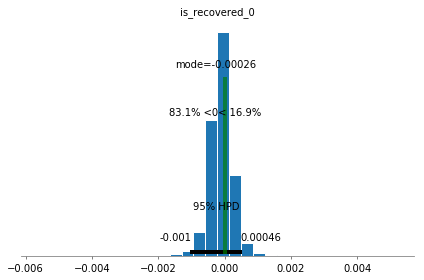

tau


/Users/felixmolter/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/felixmolter/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4385: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 286.75:  29%|██▉       | 14524/50000 [00:12<00:30, 1164.98it/s]
Convergence archived at 14600
Interrupted at 14,599 [29%]: Average Loss = 535.6
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [value_sd_interval__, is_recovered|dataset_offset, is_recovered|dataset_sd_log__, 1|dataset_offset, 1|dataset_sd_log__, is_recovered, Intercept]
100%|██████████| 30500/30500 [04:39<00:00, 109.22it/s]
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There we

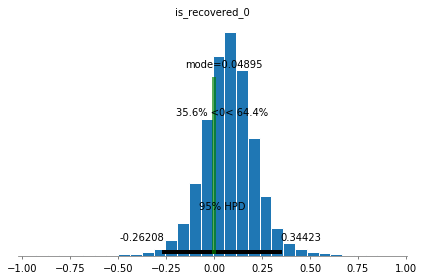

In [8]:
bias_analysis_results = {}
models = {}

n_samples = 30000

parameters = ['v', 'gamma', 's', 'tau']

for parameter in parameters:
    print(parameter)
    
    model = Model(df.loc[df['parameter'] == parameter].reset_index(drop=True).copy())
    models[parameter] = model
    result = model.fit('value ~ is_recovered',
                       random=['is_recovered|dataset'],
                       categorical=['dataset'],
                       samples=n_samples,
                       chains=2)
    bias_analysis_results[parameter] = result
    
    plot_posterior(model.backend.trace,
                   varnames=['is_recovered'],
                   round_to=5,
                   point_estimate='mode',
                   ref_val=0)
    plt.show()

In [9]:
for parameter in parameters:
    print('\n')
    print(parameter)
    print(bias_analysis_results[parameter].summary())
    print('\n')
    print('\n')



v
                                 mean        sd  hpd0.95_lower  hpd0.95_upper  \
is_recovered|dataset_sd  6.944117e-06  0.000008   2.424827e-10       0.000022   
Intercept                6.495682e-05  0.000015   3.537772e-05       0.000096   
is_recovered            -8.792129e-08  0.000006  -1.253942e-05       0.000012   
1|dataset_sd             2.967314e-05  0.000011   1.235379e-05       0.000052   
value_sd                 3.021681e-05  0.000001   2.752822e-05       0.000033   

                         effective_n  gelman_rubin  
is_recovered|dataset_sd        14226      0.999997  
Intercept                      42190      0.999986  
is_recovered                   33109      1.000066  
1|dataset_sd                   40817      0.999985  
value_sd                       46980      1.000127  






gamma
                             mean        sd  hpd0.95_lower  hpd0.95_upper  \
is_recovered|dataset_sd  0.085506  0.092726       0.000012       0.263656   
Intercept                